In [46]:
# Setup autoreload
%load_ext autoreload
%autoreload 2

# Give yourself access to common
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from common import *
FUT_SAL_CLASS = 'future_salary_class'

def add_future_salary_class(nba: pd.DataFrame):
    FUT_SAL_CLASS = 'future_salary_class'
    max = nba[NEXT_Y_SAL].max()
    min = nba[NEXT_Y_SAL].min()
    nba[FUT_SAL_CLASS] = nba[NEXT_Y_SAL].apply(lambda x: get_salary_class(x,max,min))

    for i, row in nba.iterrows() :
        next_val = nba.loc[((nba[P_NAME] == row[P_NAME]) & (nba[SZN_START_Y] == (row[SZN_START_Y]+1)))]  
        if not next_val.empty :
            nba.loc[i,'y'] = next_val.index[0]
        else :
            nba.loc[i,'y'] = np.nan
    return nba.drop(P_NAME, axis=1)
    
    


In [48]:
from sklearn.preprocessing import StandardScaler
def extract_features(nba: pd.DataFrame):
    # Normalize the data
    print(nba.columns)
    # print(y.columns)
    feats = nba.columns[1:-3]
    feats = list(feats)
    feats = feats + [FUT_SAL_CLASS]
    base_feats = feats[:15]
    print(feats)
    print(base_feats)

    X = pd.DataFrame(columns=feats)
    y = pd.DataFrame()
    X = nba.copy(deep=True)
    X = X.dropna()
    y = nba.loc[X['y']]

    X = X[feats]
    y = y[feats]
    print(X.columns)
    print(y.columns)
    # Scale the stuff down
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    y_scaled = scaler.transform(y)
    y_scaled = y_scaled[:,:(len(base_feats))]

    # Sanity check the scaler
    print((X['FG']).iloc[0])
    print(X_scaled[0, X.columns.get_loc('FG')])
    inv = scaler.inverse_transform(X_scaled)
    print(inv[0, X.columns.get_loc('FG')])


    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25, random_state=42)
    
    ret_vals = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_scaled': X_scaled,
        'feats': feats,
        'base_feats': base_feats,
        'X': X,
        'y': y,
        'scaler': scaler
    }
    
    return ret_vals

In [49]:
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
def train_model(X_train, X_test, y_train, y_test):
    # Fit the model

    # MLPClassifier only classifies data as integers or strings, therefore, our problem is one of regression for the neural network
    # Consequently I should use the mlp regressor
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), solver='adam', max_iter=1000)
    mlp.fit(X_train,y_train)

    # Evaluate the model
    predict_test = mlp.predict(X_test)
    test_set_rsquared = mlp.score(X_test, y_test)
    test_set_rmse = np.sqrt(mean_squared_error(predict_test, y_test))
    test_set_mse = mean_squared_error(predict_test, y_test)
    print('R_squared value: ', test_set_rsquared) # Variances are not nicely correlated
    print('RMSE: ', test_set_rmse) # Fairly good at data prediction
    print('MSE:', test_set_mse)
    
    return mlp

In [50]:
def denormalize_data(mlp: MLPRegressor, X_scaled, X_train, scaler: StandardScaler, base_feats, y):
    # Denormalize the data
    predict_test = mlp.predict((X_scaled[0]).reshape(1,-1))
    print(X_train.shape[1])
    print(predict_test)
    tmp = np.zeros((1,X_train.shape[1]))
    tmp[:,:predict_test.shape[1]] = predict_test
    print(tmp)
    undone = scaler.inverse_transform(tmp)
    print(undone.flatten().tolist()[:13])
    print(y[base_feats].iloc[0])

In [51]:
def create_confidence_intervals(mlp: MLPRegressor, X_scaled, scaler: StandardScaler, y, base_feats):

    # Get the unscaled predictions
    predict_full = mlp.predict(X_scaled)
    tmp = np.zeros(X_scaled.shape)
    tmp[:,:predict_full.shape[1]] = predict_full
    predicted_unscaled_vals = scaler.inverse_transform(tmp)
    predicted_unscaled_vals = predicted_unscaled_vals[:,:predict_full.shape[1]]

    # compute the RMSE for each feature in the output vector
    actual_unscaled_vals = y[base_feats].values
    rmse = np.sqrt(np.square(predicted_unscaled_vals - actual_unscaled_vals))

    # compute the percentilse of the RMSE to get the confidence interval of each predicted feature
    ci_up = np.percentile(rmse, 95, axis=0) # 95th percentile
    ci_low = np.percentile(rmse, 5, axis=0) # 5th percentile
    # print("Off by at most this much:", ci_up.flatten().tolist())
    # print(np.max(actual_unscaled_vals, axis=0))
    # print(np.min(actual_unscaled_vals, axis=0)) 
    # print(ci_low.flatten().tolist()) 

    # TODO: validate these findings with the very basic network to see if it predicts that these stats will land us in our desired class
    np.set_printoptions(suppress=True, precision=4)
    # requires the assumption of gaussianity, but seems to be working?
    conf_interval = confidence_interval_numpy(predicted_unscaled_vals, actual_unscaled_vals)
    # print(conf_interval) 


    print(bootstrap_confidence_interval(predicted_unscaled_vals, actual_unscaled_vals)) # should be able to work without the assumption of gaussianity
    # computing for rmse, so says that the true root mean squared error has a 95% of landing in these intervals
    # residuals are likely far smaller because you have the negatives balancing things out so it is going to be less accurate for computing the confidence interval

    residuals = predicted_unscaled_vals - actual_unscaled_vals
    ci = np.quantile(residuals, 1 - 0.05, axis=0)
    
    return actual_unscaled_vals, conf_interval

In [52]:
def scale_values(data, intervals):
    
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)
    
    
    
    # scaled_values = (intervals - min_values) / (max_values - min_values)
    first_vals = (intervals[:, 0]) / (max_values - min_values)
    second_vals = (intervals[:, 1]) / (max_values - min_values)
    
    return first_vals, second_vals

In [53]:
import matplotlib.pyplot as plt

def plot_intervals(actual_unscaled_vals, conf_interval, base_feats, color='blue'):

    lower, upper = scale_values(actual_unscaled_vals, conf_interval)

    data_dict = {
        'category': base_feats,
        'lower': lower,
        'upper': upper
    }

    plotset = pd.DataFrame(data_dict)

    for lower,upper,y in zip(plotset['lower'],plotset['upper'],range(len(plotset))):
        plt.plot((lower,upper),(y,y),'-',color=color)
        
    return plotset


In [54]:
def run_everything(nba: pd.DataFrame):
    nba = add_future_salary_class(nba)
    
    ret_vals = extract_features(nba)
    
    mlp = train_model(ret_vals['X_train'], ret_vals['X_test'], ret_vals['y_train'], ret_vals['y_test'])
    
    # denormalize_data(mlp, )
    actual_unscaled_vals, conf_interval = create_confidence_intervals(mlp, ret_vals['X_scaled'], ret_vals['scaler'], ret_vals['y'], ret_vals['base_feats'])
    # plot_intervals(actual_unscaled_vals, conf_interval, ret_vals['base_feats'])
    return actual_unscaled_vals, conf_interval, ret_vals['base_feats']
    
    

Index(['seasonStartYear', 'MP', 'PTS', 'Age', 'games', 'games_started', 'PER',
       'FTr', 'AST', 'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight',
       'inflationAdjSalary', 'next_year_salary', 'future_salary_class', 'y'],
      dtype='object')
['MP', 'PTS', 'Age', 'games', 'games_started', 'PER', 'FTr', 'AST', 'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight', 'inflationAdjSalary', 'future_salary_class']
['MP', 'PTS', 'Age', 'games', 'games_started', 'PER', 'FTr', 'AST', 'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight']
Index(['MP', 'PTS', 'Age', 'games', 'games_started', 'PER', 'FTr', 'AST',
       'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight',
       'inflationAdjSalary', 'future_salary_class'],
      dtype='object')
Index(['MP', 'PTS', 'Age', 'games', 'games_started', 'PER', 'FTr', 'AST',
       'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight',
       'inflationAdjSalary', 'future_salary_class'],
      dtype='object')
655.0
2.228594445658938
655.0
R_squared value: 

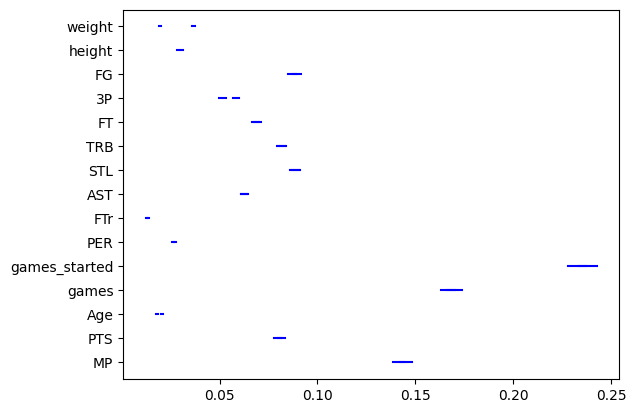

In [55]:
# Gather training and testing data and process it to be configured for time intervals
from common import *
from sklearn.model_selection import train_test_split
import pandas as pd

nba = get_cleaned_baseline_data(next_year_salary=True)
base_vals, base_interval, _ = run_everything(nba)


nba = get_cleaned_external_data(next_year_salary=True)
ext_vals, ext_interval, base_feats = run_everything(nba)


# max = nba[NEXT_Y_SAL].max()
# min = nba[NEXT_Y_SAL].min()
# nba[FUT_SAL_CLASS] = nba[NEXT_Y_SAL].apply(lambda x: get_salary_class(x,max,min))

# for i, row in nba.iterrows() :
#     next_val = nba.loc[((nba[P_NAME] == row[P_NAME]) & (nba[SZN_START_Y] == (row[SZN_START_Y]+1)))]  
#     if not next_val.empty :
#         nba.loc[i,'y'] = next_val.index[0]
#     else :
#         nba.loc[i,'y'] = np.nan
# nba = nba.drop(P_NAME, axis=1)
# run_everything(nba)
# nba = add_future_salary_class(nba)

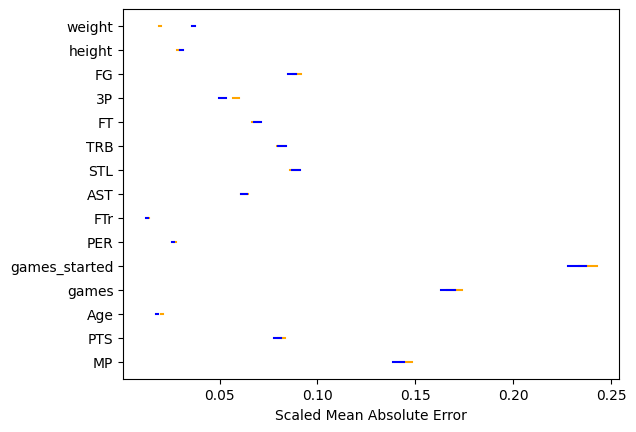

In [64]:

plot_intervals(base_vals, base_interval, base_feats, color='orange')
plotset = plot_intervals(ext_vals, ext_interval, base_feats)


plt.yticks(range(len(plotset)),list(plotset['category']))
plt.xlabel('Scaled Mean Absolute Error')
plt.title('95% Confidence Intervals of Scaled Mean Absolute Error for Each Base Feature')
plt.show()

In [56]:

# # Normalize the data
# print(nba.columns)
# # print(y.columns)
# feats = nba.columns[1:-3]
# feats = list(feats)
# feats = feats + [FUT_SAL_CLASS]
# base_feats = feats[:15]
# print(feats)
# print(base_feats)

# X = pd.DataFrame(columns=feats)
# y = pd.DataFrame()
# X = nba.copy(deep=True)
# X = X.dropna()
# y = nba.loc[X['y']]

# X = X[feats]
# y = y[feats]
# print(X.columns)
# print(y.columns)
# # Scale the stuff down
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X)
# X_scaled = scaler.transform(X)
# y_scaled = scaler.transform(y)
# y_scaled = y_scaled[:,:(len(base_feats))]

# # Sanity check the scaler
# print((X['FG']).iloc[0])
# print(X_scaled[0, X.columns.get_loc('FG')])
# inv = scaler.inverse_transform(X_scaled)
# print(inv[0, X.columns.get_loc('FG')])


# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25, random_state=42)

In [57]:


# # Fit the model
# from sklearn.neural_network import MLPRegressor
# import numpy as np

# # MLPClassifier only classifies data as integers or strings, therefore, our problem is one of regression for the neural network
# # Consequently I should use the mlp regressor
# mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), solver='adam', max_iter=1000)
# mlp.fit(X_train,y_train)

# # Evaluate the model
# import numpy as np
# from sklearn.metrics import mean_squared_error
# predict_test = mlp.predict(X_test)
# test_set_rsquared = mlp.score(X_test, y_test)
# test_set_rmse = np.sqrt(mean_squared_error(predict_test, y_test))
# test_set_mse = mean_squared_error(predict_test, y_test)
# print('R_squared value: ', test_set_rsquared) # Variances are not nicely correlated
# print('RMSE: ', test_set_rmse) # Fairly good at data prediction
# print('MSE:', test_set_mse)
# y_test

In [58]:
# # Denormalize the data
# predict_test = mlp.predict((X_scaled[0]).reshape(1,-1))
# print(X_train.shape[1])
# print(predict_test)
# tmp = np.zeros((1,X_train.shape[1]))
# tmp[:,:predict_test.shape[1]] = predict_test
# print(tmp)
# undone = scaler.inverse_transform(tmp)
# print(undone.flatten().tolist()[:13])
# print(y[base_feats].iloc[0])

In [59]:
# Compute the confidence interval of each of the features
# from common import *

# # Get the unscaled predictions
# predict_full = mlp.predict(X_scaled)
# tmp = np.zeros(X_scaled.shape)
# tmp[:,:predict_full.shape[1]] = predict_full
# predicted_unscaled_vals = scaler.inverse_transform(tmp)
# predicted_unscaled_vals = predicted_unscaled_vals[:,:predict_full.shape[1]]

# # compute the RMSE for each feature in the output vector
# actual_unscaled_vals = y[base_feats].values
# rmse = np.sqrt(np.square(predicted_unscaled_vals - actual_unscaled_vals))

# # compute the percentilse of the RMSE to get the confidence interval of each predicted feature
# ci_up = np.percentile(rmse, 95, axis=0) # 95th percentile
# ci_low = np.percentile(rmse, 5, axis=0) # 5th percentile
# # print("Off by at most this much:", ci_up.flatten().tolist())
# # print(np.max(actual_unscaled_vals, axis=0))
# # print(np.min(actual_unscaled_vals, axis=0)) 
# # print(ci_low.flatten().tolist()) 

# # TODO: validate these findings with the very basic network to see if it predicts that these stats will land us in our desired class
# np.set_printoptions(suppress=True, precision=4)
# # requires the assumption of gaussianity, but seems to be working?
# conf_interval = confidence_interval_numpy(predicted_unscaled_vals, actual_unscaled_vals)
# # print(conf_interval) 


# print(bootstrap_confidence_interval(predicted_unscaled_vals, actual_unscaled_vals)) # should be able to work without the assumption of gaussianity
# # computing for rmse, so says that the true root mean squared error has a 95% of landing in these intervals
# # residuals are likely far smaller because you have the negatives balancing things out so it is going to be less accurate for computing the confidence interval

# residuals = predicted_unscaled_vals - actual_unscaled_vals
# ci = np.quantile(residuals, 1 - 0.05, axis=0)
# # print("HELLO")
# # print(ci)

# I want to say that my prediction is between these 2 bounds with 95% confidence
# The two functions I provided seem to find the rmse of each parameter with 95% confidence
# the first and 4th method I try do not scale the mean of the data and therefore, I don't think they necessarily apply to giving me the confidence interval I desire



# DO A CASE STUDY on an individual
# ANALYZE THIS MODEL ON BASELINE AND EXTERNAL




In [60]:
# def scale_values(data, intervals):
    
#     min_values = np.min(data, axis=0)
#     max_values = np.max(data, axis=0)
    
    
    
#     # scaled_values = (intervals - min_values) / (max_values - min_values)
#     first_vals = (intervals[:, 0]) / (max_values - min_values)
#     second_vals = (intervals[:, 1]) / (max_values - min_values)
    
#     return first_vals, second_vals

In [61]:
# import matplotlib.pyplot as plt

# lower, upper = scale_values(actual_unscaled_vals, conf_interval)

# data_dict = {
#     'category': base_feats,
#     'lower': lower,
#     'upper': upper
# }

# plotset = pd.DataFrame(data_dict)

# for lower,upper,y in zip(plotset['lower'],plotset['upper'],range(len(plotset))):
#     plt.plot((lower,upper),(y,y),'-',color='blue')
# plt.yticks(range(len(plotset)),list(plotset['category']))

# plt.show()